In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from langdetect import detect
from langdetect import detect_langs
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#nltk.downloader.download('vader_lexicon')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [2]:
df = pd.read_csv('./HongKong/hk_reviews.csv')
df_test = df.head(n=100)

### 1. Cleaning reviews file (filter out nulls and non-english reviews)

In [3]:
#df_input = df_test
df_input = df
df_input.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,69074,181973,2011-02-14,358597,Chi Yan,Lovely apartment in a great location that quic...
1,69074,252237,2011-05-05,467243,Doreen,"As a former resident of HK, I can say that Amy..."
2,69074,400484,2011-07-27,696753,Michael,I stayed in this Apt for about 12 days. Such a...
3,69074,411022,2011-08-01,40901,Donna,"Amy's cute, comfortable apartment is in the he..."
4,69074,497498,2011-09-03,341618,Melissa,Amy was the perfect host - extremely communica...


In [4]:
df_input.shape

(139787, 6)

In [5]:
# classify language of review
def get_language(x):
    try:
        language = detect(x)
    except:
        language = "error"

    return language
        

In [6]:
df_input['language'] = df_input["comments"].apply(get_language)

In [7]:
# save file with language classification to csv 
df_input.to_csv('./HongKong/hk_reviews_language.csv', index=False)

In [8]:
df_input.shape

(139787, 7)

In [9]:
df_input.groupby('language').count()

,listing_id,id,date,reviewer_id,reviewer_name,comments
language,,,,,,
af,276,276,276,276,276,276
bg,3,3,3,3,3,3
ca,106,106,106,106,106,106
cs,149,149,149,149,149,149
cy,69,69,69,69,69,69
da,41,41,41,41,41,41
de,389,389,389,389,389,389
el,1,1,1,1,1,1
en,73241,73241,73241,73241,73241,73241


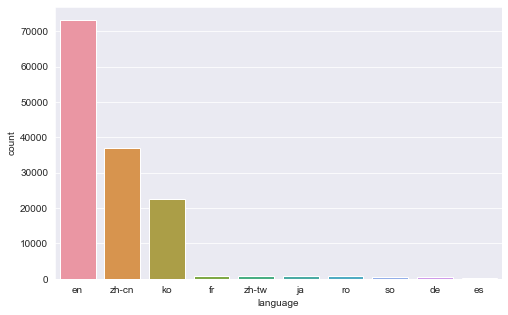

In [13]:
df_input = pd.read_csv('./HongKong/hk_reviews_language.csv')
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.countplot(x='language', data=df_input, order=pd.value_counts(df_input['language']).iloc[:10].index)
plt.savefig('./HongKong/hk_review_lang_dist.png')

## 2. Run sentiment analysis on english reviews only 

In [11]:
# run sentiment analysis on english reviews only 
df_english = df_input.loc[df_input['language'] == 'en']
df_english.shape

(73241, 7)

In [12]:
ss = SentimentIntensityAnalyzer()

In [13]:
def apply_sentiment(val, ss):
    val = str(val)
    return ss.polarity_scores(val)['compound']

In [14]:
df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)

<ipython-input-14-e48b027d7231>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['sentiment'] = df_english['comments'].apply(apply_sentiment, ss = ss)


In [15]:
df_english.to_csv('./HongKong/hk_sentiment.csv',index = False)

In [16]:
df_english.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,69074,181973,2011-02-14,358597,Chi Yan,Lovely apartment in a great location that quic...,en,0.9565
1,69074,252237,2011-05-05,467243,Doreen,"As a former resident of HK, I can say that Amy...",en,0.9660
2,69074,400484,2011-07-27,696753,Michael,I stayed in this Apt for about 12 days. Such a...,en,0.6996
3,69074,411022,2011-08-01,40901,Donna,"Amy's cute, comfortable apartment is in the he...",en,0.9665
4,69074,497498,2011-09-03,341618,Melissa,Amy was the perfect host - extremely communica...,en,0.9601


## 3. Create new features based on positive and negative reviews

In [17]:
df_sent = df_english[['listing_id', 'sentiment']]
df_sent.reset_index(inplace=True)
del df_sent['index']

In [18]:
# create new column with positive and negative classifications
def sentiment_classification(x):
    if x >= 0.05 : 
        classification = 'positive' 
  
    elif x <= - 0.05 : 
        classification = 'negative'
  
    else : 
        classification = 'neutral'
    return classification
  
df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_sent.head()

<ipython-input-18-9c187e4199fe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sent['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)


,listing_id,sentiment,sentiment_class
0,69074,0.9565,positive
1,69074,0.9660,positive
2,69074,0.6996,positive
3,69074,0.9665,positive
4,69074,0.9601,positive


In [19]:
#create two new features, avg_sentiment_score and proportion_positive

def pos_proportion(x):
    v = np.sum(x=='positive')/len(x)
    return v 

df_avg_sent = df_sent.groupby('listing_id', group_keys = False, as_index = False).agg({
    'sentiment': np.mean,
    'sentiment_class' : pos_proportion})

In [20]:
df_avg_sent.head()

,listing_id,sentiment,sentiment_class
0,69074,0.907480,0.991870
1,75083,0.849066,0.967742
2,103760,0.782564,0.944000
3,104626,0.925592,1.000000
4,132773,0.841314,0.978378


In [21]:
df_avg_sent.rename(columns={'sentiment': 'avg_sentiment_score', 'sentiment_class': 'proportion_positive'}, inplace=True)
df_avg_sent.to_csv('./HongKong/hk_sentiment_features.csv', index = False)

## Exploratory sentiment analysis

In [22]:
df_neighborhoods = pd.read_csv('../data_input/HongKong/hk_listings_full.csv')
df_neighborhoods.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,69074,https://www.airbnb.com/rooms/69074,20201025050911,2020-10-25,Beautiful oasis of plants & art @ best location,An ideal Hong location any visitor--hip withou...,"In the upper part of trendy, hip Sheung Wan, w...",https://a0.muscache.com/pictures/84364564/1e0c...,160139,https://www.airbnb.com/users/show/160139,...,10.0,10.0,9.0,NaN,f,1,1,0,0,1.13
1,75083,https://www.airbnb.com/rooms/75083,20201025050911,2020-10-25,SoHo off Hollywood Road 3B,"Located steps from Hollywood road, with new ea...",NaN,https://a0.muscache.com/pictures/2873745/90c15...,304876,https://www.airbnb.com/users/show/304876,...,9.0,10.0,9.0,NaN,f,13,9,4,0,1.95
2,103760,https://www.airbnb.com/rooms/103760,20201025050911,2020-10-25,Central Centre 5 min walk to/from Central MTR,"Located right in the heart of Central, this 2 ...",NaN,https://a0.muscache.com/pictures/815221/056993...,304876,https://www.airbnb.com/users/show/304876,...,10.0,10.0,9.0,NaN,f,13,9,4,0,2.39
3,104626,https://www.airbnb.com/rooms/104626,20201025050911,2020-10-25,Entire Flat - Next to Man Mo Temple,<b>The space</b><br />Situated in one of Hong ...,NaN,https://a0.muscache.com/pictures/1947265/ef01a...,544166,https://www.airbnb.com/users/show/544166,...,10.0,10.0,9.0,NaN,t,1,1,0,0,0.12
4,132773,https://www.airbnb.com/rooms/132773,20201025050911,2020-10-25,Fabulous 2 Bdrm Aprt Open kitchen,"Nicely decorated, spacious 2 bedroom apartment...",The Sheung Wan neighbourhood is ever changing ...,https://a0.muscache.com/pictures/36936441/e4c1...,304876,https://www.airbnb.com/users/show/304876,...,10.0,10.0,10.0,NaN,f,13,9,4,0,3.14


In [33]:
df = pd.read_csv('./HongKong/hk_sentiment.csv')
df_neighborhoods = pd.read_csv('../data_input/HongKong/hk_listings_full.csv')
df_neighborhoods = df_neighborhoods[['id', 'neighbourhood_group_cleansed']]
df_neighborhoods.head()

,id,neighbourhood_group_cleansed
0,69074,NaN
1,75083,NaN
2,103760,NaN
3,104626,NaN
4,132773,NaN


### Show sentiment by borough

In [34]:
df_merged = pd.merge(df, df_neighborhoods,  how='left', left_on=['listing_id'], right_on = ['id'])
df_merged.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,language,sentiment,id_y,neighbourhood_group_cleansed
0,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,en,0.9248,2595,Manhattan
1,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",en,0.9229,2595,Manhattan
2,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,en,0.9464,2595,Manhattan
3,2595,1238204,2012-05-07,1783688,Sergey,Hi to everyone!\r\nWould say our greatest comp...,en,0.9869,2595,Manhattan
4,2595,1293632,2012-05-17,1870771,Loïc,"Jennifer was very friendly and helpful, and he...",en,0.9668,2595,Manhattan


In [35]:
df_merged.drop(columns=['id_y'], inplace=True)

In [38]:
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})
df_avg_sent_borough

,neighbourhood_group_cleansed,sentiment
0,Bronx,0.783458
1,Brooklyn,0.835924
2,Manhattan,0.819786
3,Queens,0.785524
4,Staten Island,0.817085


In [38]:
x = df_avg_sent_borough['neighbourhood_group_cleansed']
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.barplot(x, y, palette='viridis')

NameError: name 'df_avg_sent_borough' is not defined

In [ ]:
df_merged['sentiment_class'] = df_sent['sentiment'].apply(sentiment_classification)
df_avg_sent_borough = df_merged.groupby('neighbourhood_group_cleansed', group_keys=False, as_index=False).agg({'sentiment': np.mean})

## Generate word cloud

In [2]:
df = pd.read_csv('./HongKong/hk_sentiment.csv')
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment
0,69074,181973,2011-02-14,358597,Chi Yan,Lovely apartment in a great location that quic...,en,0.9565
1,69074,252237,2011-05-05,467243,Doreen,"As a former resident of HK, I can say that Amy...",en,0.9660
2,69074,400484,2011-07-27,696753,Michael,I stayed in this Apt for about 12 days. Such a...,en,0.6996
3,69074,411022,2011-08-01,40901,Donna,"Amy's cute, comfortable apartment is in the he...",en,0.9665
4,69074,497498,2011-09-03,341618,Melissa,Amy was the perfect host - extremely communica...,en,0.9601


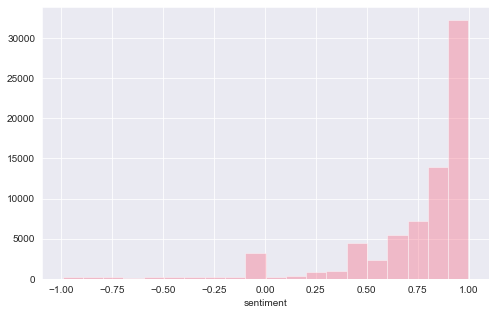

In [3]:
plt.figure(figsize = (8,5))
sns.color_palette("husl", 8)
sns.set_palette('husl')
sns.set_style("darkgrid")
sns.distplot(df['sentiment'], kde = False, bins = 20)

In [4]:
df.shape

(73241, 8)

In [5]:
df_positive = df[df['sentiment']>.98]['comments']

In [6]:
df_neg = df[df['sentiment']<.05]['comments']

In [7]:
pos_text = ' '.join(list(df_positive))

post_text = pos_text.replace('\r','')
post_text = pos_text.replace('\n','')

In [8]:
neg_text = ' '.join(list(df_neg))

neg_text = neg_text.replace('\r','')
neg_text = neg_text.replace('\n','')

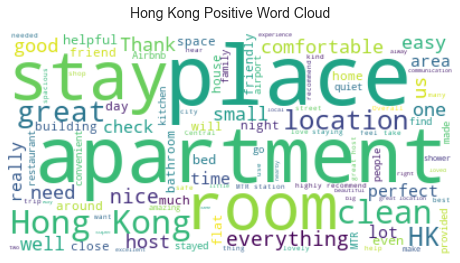

In [9]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')

wordcloud.generate(pos_text, )

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (8,5))
plt.title('Hong Kong Positive Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.savefig('./HongKong/hk_pos_word_cloud.png', bbox_inches='tight')

In [31]:
# save wordcloud 

wordcloud.to_file('./HongKong/hk_pos_word_cloud.png')

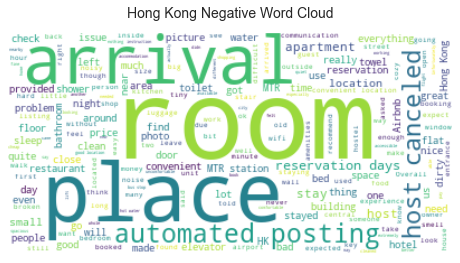

In [10]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')
wordcloud.generate(neg_text,)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.title('Hong Kong Negative Word Cloud', fontsize=14, pad=15)
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.savefig('./HongKong/hk_neg_word_cloud.png', bbox_inches='tight')